# Poker Agent V15: 6-Max Table Training

Key features:
- 6-player table (agent + 5 opponent types)
- Position-aware rewards
- Multi-way pot risk penalties
- Agent at random position each hand
- Dynamic epsilon decay based on training duration

In [1]:
import sys
import os
# Add project root and src directories to path
project_root = os.path.dirname(os.path.dirname(os.path.abspath(__file__))) if '__file__' in dir() else os.getcwd()
while 'src' not in os.listdir(project_root) and project_root != '/':
    project_root = os.path.dirname(project_root)
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'src', 'models'))
sys.path.insert(0, os.path.join(project_root, 'src', 'workers'))

import os
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp

from poker_worker_v15 import run_single_episode_v15, POSITION_NAMES
from poker_model_v15 import (
    DuelingPokerNet, PrioritizedReplayBuffer, NUM_ACTIONS_V15,
    compute_hand_strength_category, compute_v15_shaped_reward
)

In [2]:
# Configuration
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Training config
NUM_WORKERS = 6
EPISODES_PER_BATCH = 12  # Slightly larger for 6-max
NUM_ACTIONS = NUM_ACTIONS_V15
STATE_DIM = 520  # Expanded for 6-max
EQUITY_ITERATIONS = 20

# Logging intervals (as percentage of total hands)
LOG_PERCENT = 2.0
CHECKPOINT_PERCENT = 10.0

Using device: cuda


In [3]:
class DuelingAgent:
    """Dueling DQN agent with PER for 6-max poker."""
    
    def __init__(self, state_dim: int = 520, hidden_dim: int = 512):
        self.device = device
        self.policy_net = DuelingPokerNet(state_dim, hidden_dim).to(device)
        self.target_net = DuelingPokerNet(state_dim, hidden_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=3e-4)
        self.buffer = PrioritizedReplayBuffer(capacity=300000)
        
        self.gamma = 0.99
        self.batch_size = 64
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.9995  # Will be recalculated dynamically
    
    def get_model_state_dict_cpu(self):
        return {k: v.cpu() for k, v in self.policy_net.state_dict().items()}
    
    def add_transitions(self, transitions):
        self.buffer.push_batch(transitions)
    
    def train_step(self) -> float:
        if len(self.buffer) < self.batch_size:
            return 0.0
        
        samples, indices, weights = self.buffer.sample(self.batch_size)
        if not samples:
            return 0.0
        
        states = torch.FloatTensor([s[0] for s in samples]).to(self.device)
        actions = torch.LongTensor([s[1] for s in samples]).to(self.device)
        rewards = torch.FloatTensor([s[2] for s in samples]).to(self.device)
        next_states = torch.FloatTensor([s[3] for s in samples]).to(self.device)
        dones = torch.FloatTensor([s[4] for s in samples]).to(self.device)
        weights = torch.FloatTensor(weights).to(self.device)
        
        # Current Q values
        q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Double DQN target
        with torch.no_grad():
            next_actions = self.policy_net(next_states).argmax(1)
            next_q = self.target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            targets = rewards + self.gamma * next_q * (1 - dones)
        
        # Weighted loss
        td_errors = q_values - targets
        loss = (weights * td_errors.pow(2)).mean()
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        # Update priorities
        self.buffer.update_priorities(indices, td_errors.detach().cpu().numpy())
        
        return loss.item()
    
    def update_target(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [4]:
def train_v15_parallel(num_hands=50000):
    """Train V15 agent on 6-max poker table."""
    agent = DuelingAgent(state_dim=STATE_DIM)
    
    # Dynamic epsilon decay based on num_hands
    total_batches = num_hands // EPISODES_PER_BATCH
    decay_batches = int(total_batches * 0.8)  # Reach min epsilon at 80% through training
    if decay_batches > 0:
        agent.epsilon_decay = (agent.epsilon_min / agent.epsilon) ** (1.0 / decay_batches)
    
    # Tracking
    all_rewards = []
    all_shaped = []
    loss_history = []
    action_counts_total = {i: 0 for i in range(NUM_ACTIONS)}
    
    # Position tracking (V15 specific)
    position_stats = {pos: {'rewards': [], 'wins': 0, 'hands': 0} 
                      for pos in range(6)}
    
    # Risk metrics
    risk_metrics = {'allin_count': 0, 'allin_with_weak': 0, 'allin_with_strong': 0}
    
    total_hands = 0
    batch_count = 0
    start_time = time.time()
    
    # Logging intervals
    log_interval = max(1, int(num_hands * LOG_PERCENT / 100))
    checkpoint_interval = max(1, int(num_hands * CHECKPOINT_PERCENT / 100))
    next_log = log_interval
    next_checkpoint = checkpoint_interval
    
    print("="*70)
    print(f"TRAINING V15: 6-MAX TABLE ({NUM_WORKERS} workers)")
    print("="*70)
    print(f"Total hands: {num_hands:,}")
    print(f"Episodes per batch: {EPISODES_PER_BATCH}")
    print(f"Total batches: {total_batches:,}")
    print(f"State dimension: {STATE_DIM}")
    print(f"Action space: {NUM_ACTIONS} actions")
    
    print(f"\nEpsilon schedule (dynamic):")
    print(f"  Start: {agent.epsilon:.2f}")
    print(f"  Target: {agent.epsilon_min:.2f} at batch {decay_batches:,} (80% of training)")
    print(f"  Decay factor per batch: {agent.epsilon_decay:.6f}")
    
    print("\nV15 Features:")
    print("  - 6-player table (5 opponent types)")
    print("  - Agent at random position each hand")
    print("  - Position-aware rewards")
    print("  - Multi-way pot risk penalties")
    print("="*70)
    
    try:
        ctx = mp.get_context('fork')
        print("\nUsing 'fork' context for multiprocessing")
    except:
        ctx = mp.get_context('spawn')
        print("\nUsing 'spawn' context for multiprocessing")
    
    with ProcessPoolExecutor(max_workers=NUM_WORKERS, mp_context=ctx) as executor:
        while total_hands < num_hands:
            model_state_dict = agent.get_model_state_dict_cpu()
            
            # Prepare episode arguments
            episode_args = []
            for i in range(EPISODES_PER_BATCH):
                seed = random.randint(0, 2**31-1)
                episode_args.append((seed, agent.epsilon, EQUITY_ITERATIONS, model_state_dict))
            
            # Run episodes in parallel
            futures = [executor.submit(run_single_episode_v15, args) for args in episode_args]
            
            batch_rewards = []
            batch_shaped = []
            batch_transitions = []
            batch_action_counts = {i: 0 for i in range(NUM_ACTIONS)}
            
            for future in as_completed(futures):
                try:
                    result = future.result()
                    
                    shaped = result['shaped_reward']
                    batch_rewards.append(result['final_reward'])
                    batch_shaped.append(shaped)
                    
                    # Update transitions with shaped reward
                    for t in result['transitions']:
                        obs, action, _, next_obs, done = t
                        reward = shaped if done else 0.0
                        batch_transitions.append((obs, action, reward, next_obs, done))
                    
                    # Track action counts
                    for a, c in result['action_counts'].items():
                        batch_action_counts[a] += c
                        action_counts_total[a] += c
                    
                    # Risk metrics
                    equities = result.get('equities', [])
                    actions = result.get('actions', [])
                    for eq, act in zip(equities, actions):
                        if act == 5:  # All-in
                            risk_metrics['allin_count'] += 1
                            strength = compute_hand_strength_category(eq)
                            if strength >= 3:
                                risk_metrics['allin_with_strong'] += 1
                            else:
                                risk_metrics['allin_with_weak'] += 1
                    
                    # Position stats
                    pos = result['position']
                    position_stats[pos]['rewards'].append(result['final_reward'])
                    position_stats[pos]['hands'] += 1
                    if result['won']:
                        position_stats[pos]['wins'] += 1
                    
                    total_hands += 1
                except Exception as e:
                    print(f"Episode error: {e}")
            
            # Add transitions and train
            agent.add_transitions(batch_transitions)
            
            loss = 0.0
            for _ in range(4):
                loss += agent.train_step()
            loss /= 4
            
            # Decay epsilon once per batch
            agent.decay_epsilon()
            batch_count += 1
            
            # Update target network
            if total_hands % 1000 < EPISODES_PER_BATCH:
                agent.update_target()
            
            all_rewards.extend(batch_rewards)
            all_shaped.extend(batch_shaped)
            if loss > 0:
                loss_history.append(loss)
            
            # Periodic logging
            if total_hands >= next_log:
                elapsed = time.time() - start_time
                speed = total_hands / elapsed
                remaining = (num_hands - total_hands) / speed / 60
                
                recent_r = np.mean(batch_rewards) if batch_rewards else 0
                recent_s = np.mean(batch_shaped) if batch_shaped else 0
                
                total_actions = sum(batch_action_counts.values())
                action_pcts = {a: batch_action_counts[a]/total_actions*100 if total_actions > 0 else 0 
                               for a in range(NUM_ACTIONS)}
                
                progress = total_hands / num_hands * 100
                print(f"Hand {total_hands:,}/{num_hands:,} ({progress:.1f}%) | Eps={agent.epsilon:.3f} | "
                      f"Avg BB: {recent_r:+.2f} | Shaped: {recent_s:+.2f} | Loss: {loss:.4f} | "
                      f"Speed: {speed:.1f} h/s | ETA: {remaining:.1f}m")
                print(f"        Actions: Fold {action_pcts[0]:.1f}% | Call {action_pcts[1]:.1f}% | "
                      f"SmR {action_pcts[2]:.1f}% | MedR {action_pcts[3]:.1f}% | LgR {action_pcts[4]:.1f}% | AllIn {action_pcts[5]:.1f}% | "
                      f"Buffer: {len(agent.buffer):,}")
                
                next_log += log_interval
            
            # Checkpoints
            if total_hands >= next_checkpoint:
                print()
                print("="*70)
                print(f"CHECKPOINT: Hand {total_hands:,} / {num_hands:,}")
                print("="*70)
                
                # Overall stats
                recent_n = min(1000, len(all_rewards))
                print(f"\nPerformance (last {recent_n} hands):")
                print(f"  Avg BB/hand: {np.mean(all_rewards[-recent_n:]):+.3f}")
                print(f"  Avg Shaped: {np.mean(all_shaped[-recent_n:]):+.3f}")
                
                # Position stats
                print(f"\nPosition Performance:")
                for pos in range(6):
                    pstats = position_stats[pos]
                    if pstats['hands'] > 0:
                        avg_bb = np.mean(pstats['rewards']) if pstats['rewards'] else 0
                        win_rate = pstats['wins'] / pstats['hands'] * 100
                        print(f"  {POSITION_NAMES[pos]}: {pstats['hands']:,} hands, "
                              f"Avg: {avg_bb:+.2f} BB, Win: {win_rate:.1f}%")
                
                # Risk analysis
                print(f"\nAll-in Analysis:")
                if risk_metrics['allin_count'] > 0:
                    strong_pct = risk_metrics['allin_with_strong'] / risk_metrics['allin_count'] * 100
                    print(f"  Total all-ins: {risk_metrics['allin_count']}")
                    print(f"  With strong hand: {risk_metrics['allin_with_strong']} ({strong_pct:.1f}%)")
                    print(f"  With weak hand: {risk_metrics['allin_with_weak']} ({100-strong_pct:.1f}%)")
                
                print("="*70)
                print()
                
                next_checkpoint += checkpoint_interval
    
    # Training complete
    total_time = time.time() - start_time
    print("\n" + "="*70)
    print("TRAINING COMPLETE")
    print("="*70)
    print(f"Total hands: {total_hands:,}")
    print(f"Total time: {total_time/60:.1f} minutes")
    print(f"Speed: {total_hands/total_time:.1f} hands/second")
    print(f"Final epsilon: {agent.epsilon:.4f}")
    
    return agent, {
        'rewards': all_rewards,
        'shaped': all_shaped,
        'loss': loss_history,
        'action_counts': action_counts_total,
        'position_stats': position_stats,
        'risk_metrics': risk_metrics,
    }

In [5]:
def evaluate_agent_v15(agent, num_hands=2000):
    """Evaluate trained agent on 6-max table."""
    print("\n" + "="*70)
    print("EVALUATION: V15 6-Max Agent")
    print("="*70)
    
    # Set epsilon to minimum for evaluation
    old_epsilon = agent.epsilon
    agent.epsilon = 0.02
    
    results = []
    position_results = {pos: [] for pos in range(6)}
    action_counts = {i: 0 for i in range(NUM_ACTIONS)}
    risk_metrics = {'allin_count': 0, 'allin_with_weak': 0, 'allin_with_strong': 0}
    
    model_state_dict = agent.get_model_state_dict_cpu()
    
    try:
        ctx = mp.get_context('fork')
    except:
        ctx = mp.get_context('spawn')
    
    with ProcessPoolExecutor(max_workers=NUM_WORKERS, mp_context=ctx) as executor:
        hands_done = 0
        while hands_done < num_hands:
            batch_size = min(EPISODES_PER_BATCH, num_hands - hands_done)
            
            episode_args = []
            for _ in range(batch_size):
                seed = random.randint(0, 2**31-1)
                episode_args.append((seed, agent.epsilon, EQUITY_ITERATIONS, model_state_dict))
            
            futures = [executor.submit(run_single_episode_v15, args) for args in episode_args]
            
            for future in as_completed(futures):
                try:
                    result = future.result()
                    results.append(result['final_reward'])
                    
                    pos = result['position']
                    position_results[pos].append(result['final_reward'])
                    
                    for a, c in result['action_counts'].items():
                        action_counts[a] += c
                    
                    # Risk tracking
                    equities = result.get('equities', [])
                    actions = result.get('actions', [])
                    for eq, act in zip(equities, actions):
                        if act == 5:
                            risk_metrics['allin_count'] += 1
                            if compute_hand_strength_category(eq) >= 3:
                                risk_metrics['allin_with_strong'] += 1
                            else:
                                risk_metrics['allin_with_weak'] += 1
                    
                    hands_done += 1
                except Exception as e:
                    print(f"Eval error: {e}")
    
    agent.epsilon = old_epsilon
    
    # Print results
    print(f"\nEvaluated {len(results)} hands")
    print(f"\nOverall Performance:")
    print(f"  Avg BB/hand: {np.mean(results):+.3f}")
    print(f"  Std dev: {np.std(results):.3f}")
    print(f"  Win rate: {sum(1 for r in results if r > 0) / len(results) * 100:.1f}%")
    print(f"  Total profit: {sum(results):+.1f} BB")
    
    print(f"\nPerformance by Position:")
    for pos in range(6):
        pres = position_results[pos]
        if pres:
            avg = np.mean(pres)
            winrate = sum(1 for r in pres if r > 0) / len(pres) * 100
            print(f"  {POSITION_NAMES[pos]}: {len(pres)} hands, Avg: {avg:+.2f} BB, Win: {winrate:.1f}%")
    
    total_actions = sum(action_counts.values())
    print(f"\nAction Distribution:")
    action_names = ['Fold', 'Call', 'SmallRaise', 'MedRaise', 'LargeRaise', 'AllIn']
    for i, name in enumerate(action_names):
        pct = action_counts[i] / total_actions * 100 if total_actions > 0 else 0
        print(f"  {name}: {pct:.1f}%")
    
    print(f"\nRisk Analysis:")
    if risk_metrics['allin_count'] > 0:
        strong_pct = risk_metrics['allin_with_strong'] / risk_metrics['allin_count'] * 100
        print(f"  All-ins: {risk_metrics['allin_count']}")
        print(f"  With strong hand: {strong_pct:.1f}%")
        print(f"  With weak hand: {100-strong_pct:.1f}%")
    else:
        print("  No all-ins during evaluation")
    
    return {
        'results': results,
        'position_results': position_results,
        'action_counts': action_counts,
        'risk_metrics': risk_metrics,
    }

In [6]:
# Train the agent
# Start with 50k hands - adjust based on training speed
agent, metrics = train_v15_parallel(num_hands=100000)

TRAINING V15: 6-MAX TABLE (6 workers)
Total hands: 100,000
Episodes per batch: 12
Total batches: 8,333
State dimension: 520
Action space: 6 actions

Epsilon schedule (dynamic):
  Start: 1.00
  Target: 0.05 at batch 6,666 (80% of training)
  Decay factor per batch: 0.999551

V15 Features:
  - 6-player table (5 opponent types)
  - Agent at random position each hand
  - Position-aware rewards
  - Multi-way pot risk penalties

Using 'fork' context for multiprocessing


/tmp/ipykernel_5023/4096764894.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.FloatTensor([s[0] for s in samples]).to(self.device)


Hand 2,004/100,000 (2.0%) | Eps=0.928 | Avg BB: -10.50 | Shaped: -11.12 | Loss: 1424.6766 | Speed: 19.4 h/s | ETA: 84.4m
        Actions: Fold 14.8% | Call 11.1% | SmR 3.7% | MedR 29.6% | LgR 14.8% | AllIn 25.9% | Buffer: 5,401
Hand 4,008/100,000 (4.0%) | Eps=0.861 | Avg BB: -39.63 | Shaped: -40.28 | Loss: 1330.6104 | Speed: 19.3 h/s | ETA: 82.9m
        Actions: Fold 3.6% | Call 14.3% | SmR 14.3% | MedR 17.9% | LgR 28.6% | AllIn 21.4% | Buffer: 11,036
Hand 6,000/100,000 (6.0%) | Eps=0.799 | Avg BB: +26.71 | Shaped: +29.55 | Loss: 1637.0083 | Speed: 19.5 h/s | ETA: 80.5m
        Actions: Fold 8.9% | Call 20.0% | SmR 26.7% | MedR 11.1% | LgR 24.4% | AllIn 8.9% | Buffer: 16,728
Hand 8,004/100,000 (8.0%) | Eps=0.741 | Avg BB: -15.96 | Shaped: -15.72 | Loss: 919.3242 | Speed: 19.5 h/s | ETA: 78.5m
        Actions: Fold 19.4% | Call 12.9% | SmR 19.4% | MedR 12.9% | LgR 25.8% | AllIn 9.7% | Buffer: 22,601
Hand 10,008/100,000 (10.0%) | Eps=0.687 | Avg BB: +6.71 | Shaped: +7.56 | Loss: 1381.21

In [7]:
# Evaluate
eval_results = evaluate_agent_v15(agent, num_hands=2000)


EVALUATION: V15 6-Max Agent

Evaluated 2000 hands

Overall Performance:
  Avg BB/hand: +9.481
  Std dev: 73.652
  Win rate: 42.0%
  Total profit: +18962.1 BB

Performance by Position:
  UTG: 316 hands, Avg: +4.52 BB, Win: 41.1%
  MP: 332 hands, Avg: +3.13 BB, Win: 43.1%
  CO: 321 hands, Avg: +16.02 BB, Win: 43.3%
  BTN: 325 hands, Avg: +11.33 BB, Win: 42.8%
  SB: 360 hands, Avg: +10.22 BB, Win: 40.6%
  BB: 346 hands, Avg: +11.54 BB, Win: 41.3%

Action Distribution:
  Fold: 5.6%
  Call: 45.8%
  SmallRaise: 9.7%
  MedRaise: 27.4%
  LargeRaise: 0.5%
  AllIn: 11.1%

Risk Analysis:
  All-ins: 812
  With strong hand: 46.1%
  With weak hand: 53.9%


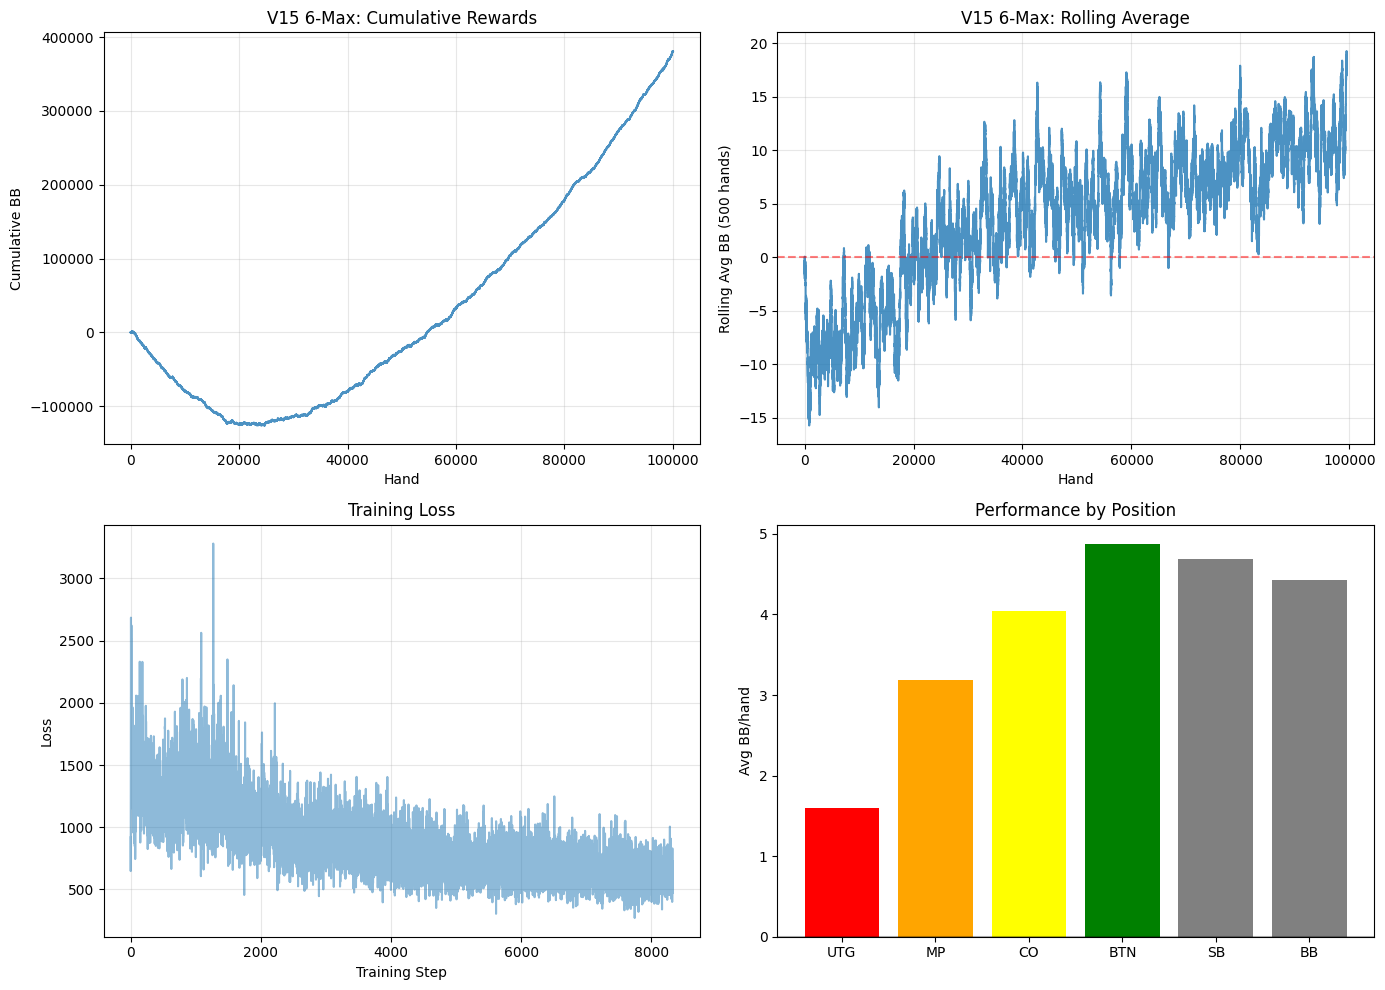

In [8]:
# Plot results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Cumulative rewards
ax1 = axes[0, 0]
cumulative = np.cumsum(metrics['rewards'])
ax1.plot(cumulative, alpha=0.8)
ax1.set_xlabel('Hand')
ax1.set_ylabel('Cumulative BB')
ax1.set_title('V15 6-Max: Cumulative Rewards')
ax1.grid(True, alpha=0.3)

# Rolling average
ax2 = axes[0, 1]
window = 500
if len(metrics['rewards']) >= window:
    rolling = np.convolve(metrics['rewards'], np.ones(window)/window, mode='valid')
    ax2.plot(rolling, alpha=0.8)
    ax2.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax2.set_xlabel('Hand')
ax2.set_ylabel('Rolling Avg BB (500 hands)')
ax2.set_title('V15 6-Max: Rolling Average')
ax2.grid(True, alpha=0.3)

# Loss history
ax3 = axes[1, 0]
if metrics['loss']:
    ax3.plot(metrics['loss'], alpha=0.5)
    ax3.set_xlabel('Training Step')
    ax3.set_ylabel('Loss')
    ax3.set_title('Training Loss')
    ax3.grid(True, alpha=0.3)

# Position performance
ax4 = axes[1, 1]
pos_avgs = []
for pos in range(6):
    rewards = metrics['position_stats'][pos]['rewards']
    pos_avgs.append(np.mean(rewards) if rewards else 0)
colors = ['red', 'orange', 'yellow', 'green', 'gray', 'gray']
bars = ax4.bar(POSITION_NAMES, pos_avgs, color=colors)
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax4.set_ylabel('Avg BB/hand')
ax4.set_title('Performance by Position')

plt.tight_layout()
plt.savefig('v15_training_results.png', dpi=150)
plt.show()

In [9]:
# Save model
torch.save({
    'model_state_dict': agent.policy_net.state_dict(),
    'metrics': metrics,
    'eval_results': eval_results,
    'config': {
        'state_dim': STATE_DIM,
        'num_actions': NUM_ACTIONS,
        'version': 'v15_6max',
    }
}, 'poker_agent_v15.pt')
print("Model saved to poker_agent_v15.pt")

Model saved to poker_agent_v15.pt
